# Heuristics Lab
The goal of this lab is to gain experience using heuristics in tandem with other algorithms.

For the purposes of this assignment, you will be implementing a solver for the "2048" game (whose implementation will already be given to you). Before continuing, the following cell contains any dependencies you may need for this assignment: 

In [191]:
import matplotlib.pyplot as plt

from game import *

You should also look at `game.py` to understand how the in-line version has been implemented. 

## Background Info

2048 is a single-player sliding block puzzle game played on a 4x4 grid where tiles containing even numbers can be moved around and merged to create larger numbers. If this does not ring a bell, it is highly recommended that you play the game at some point (enjoy the cupcake version [here](https://0x0800.github.io/2048-CUPCAKES/)).

While the implementation has been given, ensure that you understand what a tile, a turn, a legal move, and when the game ends is.

This particular implementation/walk through focuses on utilization of heuristic functions themselves (or strategies that are simple enough that a human player could follow them) & only looks ahead by 1 move (as opposed to adding this heuristic into another algorithm like nimimax or expectimax - which would yield better results)

Questions: 
1. What is a potential representation of the solution space?
2. How can you evaluate the results of a single move? 
3. How might you select and combine heuristics?
4. How can you evaluate the results of an entire game?


## A. Assessing the Problem

What is a potential representation of the solution space?

 A potential representation of the solution space could be a tree where each node is a board state, and edges represent possible moves. Each state has a utility score based on a heuristic.

Play a SINGLE round of 2048 (you can do this on the website with the nice UI instead of the text version). What score did you get?

3388 points in 277 moves


## B. Evaluating a Single Move

Before implementing specific heuristics, a general implementation procedure must be formed.

Use the following pseudocode to write a function to evaluate a game _G_ in its current state:

**Input:** _G_ - a game, _M_ - a set of moves \
**Output:** The best moves according to the specific evaluator

**procedure** EvaluateGame(_G_, _M_)\
&emsp;_bestScore_ ← −1\
&emsp;_bestMoves_ ← ∅\
&emsp;**for all** _move_ ∈ _M_ **do**\
&emsp;&emsp;_G'_ ← _G_\
&emsp;&emsp;apply _move_ to _G'_\
&emsp;&emsp;_curScore_ ← the score given by the evaluator’s specific criteria\
&emsp;&emsp;**if** _curScore_ > _bestScore_ **then**\
&emsp;&emsp;&emsp;_bestScore_ ← _curScore_\
&emsp;&emsp;&emsp;_bestMoves_ ← {_move_}\
&emsp;&emsp;**else if** _curScore_ = _bestScore_ **then**\
&emsp;&emsp;&emsp;_bestMoves_ ← _bestMoves_ ∪ {_move_}\
&emsp;&emsp;**end if**\
&emsp;**end for**\
&emsp;return _bestMoves_\
**end procedure**

For now, use the overall game score as the evaluation criteria. Remember to consider how the game/board is referenced when running each move.

In [192]:
from game import Board
def evaluate_game(game, moves): 
    best_score = -1
    best_moves = []
    
    for move in moves:
        game_copy = game.clone()
        game_copy.move(move)
        cur_score = heuristic(game_copy)
        
        if cur_score > best_score:
            best_score = cur_score
            best_moves = [move]
        elif cur_score == best_score:
            best_moves.append(move)
    
    return best_moves

## C. Selecting Heuristics

### Refactoring Evaluation

At this point in time, the solver uses a 'greedy' heuristic of purely selecting tiles based on the highest immediate increase to score.  Before we try other heuristics, let's refactor the `evaluate_move()` function to take in a heuristic function instead of hardcoding the evaluator's criteria. 

After updating the function, it can be tested with the given `game_score()` heuristic function.

In [193]:
def game_score(game):
    return game.score

def evaluate_game (game, moves, heuristic): 
    for move in moves:
        # Create a copy of the game state
        game_copy = game
        # game_copy.board = game.board.copy()  
        game_copy.score = game.score 
        best_score = -1

        if game_copy.play_turn(move):  # Only consider valid moves
            cur_score = heuristic(game_copy)

            if cur_score > best_score:
                best_score = cur_score
                best_moves = [move]
            elif cur_score == best_score:
                best_moves.append(move)
    
    return best_moves

We should also define a random move selection function as a groud zero/baseline point of comparison.

In [194]:
def random_move(moves):
    return random.choice(moves)

### Various Heuristics

There are multiple heuristics that can be used to solve a 2048 game: 
- Greedy - approximates in-game score after each move & return the one with the highest result
- Monotincity - values are either non-increasing or non-decreasing along all rows and non-increasing or non-decreasing along all columns
- Empty - prioritizes moves that increases the # of empty tiles on the board
- Smoothness - keeps tiles of similar value close to each other
- Weight matrix - a grid w higher weighting tiles on one part of the grid (resulting in higher utility & the algorithm shifting tiles/converging them on one corner of weights)

Pick two heuristics (other than greedy - which you already did) & write functions calculating those. You may choose another heuristic that is not on this list if you would prefer that.

In [195]:
import numpy as np

def empty_tiles_heuristic(game):
    return int(np.count_nonzero(game.board == 0))

def monotonicity_heuristic(game):
    board = game.board
    score = 0

    for row in board:
        for i in range(3):
            if row[i] >= row[i + 1]:
                score += row[i]
    
    for col in board.T:
        for i in range(3):
            if col[i] >= col[i + 1]:
                score += col[i]
    
    return int(score)


## D. Evaluating a Game

### Making the Solver

Now that value has successfully been equated to the outcome of a single move, this needs to be done on the entire game. 

To start, your solver should take in a game and a heuristic to abide by. 

Most heuristic evaluators are non-terminal, meaning they will return more than one possible move of equal value. In order to combat this, a terminal evaluator must be included in the overall game solver to ensure only one move is selected. This can be done by randomly selecting from the list of "best moves" provided by the heuristic. 

In [196]:
def run_solver(game, heuristic):
    previous_move = None
    repeat_count = 0
    max_repeats = 5

    while game.has_valid_moves():
        moves = ['w', 'a', 's', 'd']
        best_moves = evaluate_game(game, moves, heuristic)
        move = random.choice(best_moves) if best_moves else random_move(moves)

        if move == previous_move:
            repeat_count += 1
        else:
            repeat_count = 0
        
        if repeat_count >= max_repeats:
            move = random_move(moves)
            repeat_count = 0

        game.play_turn(move)
        previous_move = move
    
    return int(game.score), game.board

Run the following cell to test your solver on just the `game_score` heuristic:

In [197]:
g = Board()
run_solver(g, game_score)

(1624,
 array([[  4,   8,  64,   2],
        [  2,  32,  16,   4],
        [  8, 128,  64,  16],
        [  2,   8,   4,   2]]))

Try the full game solver on some of your other heuristics. Note that sometimes they will flatline or get stuck in a pattern of moves that do not appear to converge in a termination point.

In [198]:
# Test other heuristics here
g = Board()
run_solver(g, empty_tiles_heuristic)

(3768,
 array([[  2,   4, 256,   2],
        [  4,   8,  32,   8],
        [  8,  16, 256,   4],
        [  2,   4,   8,  16]]))

In [199]:
g = Board()
run_solver(g, monotonicity_heuristic)

(2340,
 array([[  2,   4,  64,   8],
        [  8, 256,   8,   2],
        [  2,   8,  32,  16],
        [ 16,   4,   2,   4]]))

#### Resolving Flatlining

One way to resolve flatlining is to to update the solver to count for a certain number of repeating moves and reintroduce a random selection.

In [200]:
def run_solver(game, heuristic): 
    threshold = 5 # Replace with your code (this can be a hardcoded value)
    previous_move = None
    repeat_count = 0

    while game.has_valid_moves():
        moves = ['w', 'a', 's', 'd']
        best_moves = evaluate_game(game, moves, heuristic)
        move = random.choice(best_moves) if best_moves else random_move(moves)

        if move == previous_move:
            repeat_count += 1
        else:
            repeat_count = 0
        
        if repeat_count >= threshold:
            move = random_move(moves)
            repeat_count = 0

        game.play_turn(move)
        previous_move = move
    
    return int(game.score), game.board

#### Combining Heuristics 

A simple way to incorporate multiple heuristics is to create a `combined_heuristic()` function that assigns weights to various heuristics. These weights can also help offset any discrepancies in the scale of resulting "scores".

The combined score should be calculated by multiplying the weight of an individual heuristic's score with its score.

In [201]:
def combined_heuristic(game):
    
    weight_empty = 0.5
    weight_monotonicity = 0.5
    # Combine heuristics
    combined_score = (weight_empty * empty_tiles_heuristic(game) +
            weight_monotonicity * monotonicity_heuristic(game))

    return combined_score

g = Board()
run_solver(g, combined_heuristic)


(2080,
 array([[  2,   4,  64,   2],
        [  4, 128,  16,   4],
        [ 16,  32,   4,   8],
        [  2,  16, 128,   2]]))

### Plotting Results

Run 100 cycles of each of your heuristics & plot your results. You should have at least 3 lines (score, your heuristic #1, your heuristic #2, and potentially a completely random implementation)

In [202]:
scores_random = []
scores_empty = []
scores_monotonicity = []
scores_combined = []

for _ in range(100):
    
    g = Board()
    scores_empty.append(run_solver(g, empty_tiles_heuristic)[0])
    
    g = Board()
    scores_monotonicity.append(run_solver(g, monotonicity_heuristic)[0])
    
    g = Board()
    scores_combined.append(run_solver(g, combined_heuristic)[0])

    # Run your solvers here

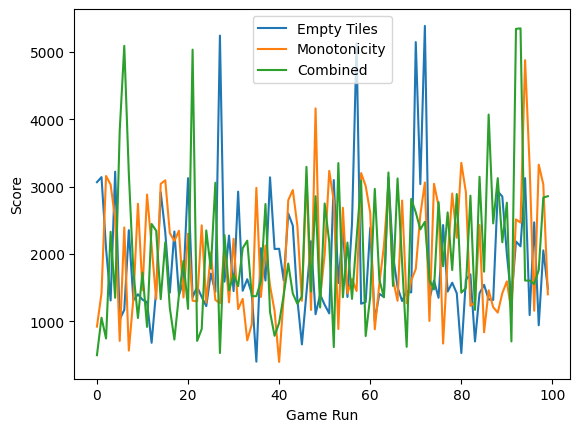

In [203]:

plt.plot(scores_empty, label='Empty Tiles')
plt.plot(scores_monotonicity, label='Monotonicity')
plt.plot(scores_combined, label='Combined')
plt.xlabel('Game Run')
plt.ylabel('Score')
plt.legend()
plt.show()